# Translator using NLP
##### Group 4: Apurva Shekhar, Harsh Tandon, Jaskaran Kohli, Ritu Ranjani Ravi Shankar, Suchita Negi

# Stage 1: Importing dependencies

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import time
import pickle
from google.colab import drive


import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Stage 2: Data preprocessing

## Loading files

Lets import files from our google drive. <br>
The files can also be found through this link http://www.statmt.org/europarl/ <br>
The data is extracted from the proceedings of the European Parliament. It includes versions in 21 European languages. The data is actually a parallel corpora of language pairs that include English.

In [0]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open("/content/drive/My Drive/en-es/europarl-v7.es-en.en",
          mode='r',
          encoding='utf-8') as f:
    english = f.read()
with open("/content/drive/My Drive/en-es/europarl-v7.es-en.es",
          mode='r',
          encoding='utf-8') as f:
    spanish = f.read()
with open("/content/drive/My Drive/en-es/nonbreaking_prefix.en",
          mode='r',
          encoding='utf-8') as f:
    non_breaking_prefix_english = f.read()
with open("/content/drive/My Drive/en-es/nonbreaking_prefix.es",
          mode='r',
          encoding='utf-8') as f:
    non_breaking_prefix_spanish = f.read()

In [0]:
print("English", english[:200])
print("Spanish", spanish[:200])
print("Non_breaking_prefix_English:", non_breaking_prefix_english[70:100])
print("Non_breaking_prefix_spanish:", non_breaking_prefix_spanish[70:100])

English Resumption of the session
I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you e
Spanish Reanudación del período de sesiones
Declaro reanudado el período de sesiones del Parlamento Europeo, interrumpido el viernes 17 de diciembre pasado, y reitero a Sus Señorías mi deseo de que hayan teni
Non_breaking_prefix_English: 
mrs
ms
ph
prof
sr
st
a.m
p.m

Non_breaking_prefix_spanish: C.AA
Da
Dep
Dn
Dr
Dra
EE.UU
Ex


## Cleaning data

Getting the non_breaking_prefixes as a clean list of words with a point at the end so it is easier to use.


In [0]:
non_breaking_prefix_english = non_breaking_prefix_english.split("\n")
non_breaking_prefix_english = [' ' + pref + '.' for pref in non_breaking_prefix_english]
non_breaking_prefix_spanish = non_breaking_prefix_spanish.split("\n")
non_breaking_prefix_spanish = [' ' + pref + '.' for pref in non_breaking_prefix_spanish]

In [0]:
print(non_breaking_prefix_english[30:40])
print(non_breaking_prefix_spanish[30:40])

[' mrs.', ' ms.', ' ph.', ' prof.', ' sr.', ' st.', ' a.m.', ' p.m.', ' vs.', ' i.e.']
[' CC.AA.', ' Da.', ' Dep.', ' Dn.', ' Dr.', ' Dra.', ' EE.UU.', ' Excmo.', ' FF.CC.', ' Fil .']


We will need each word and other symbol that we want to keep to be in lower case and separated by spaces so we can "tokenize" them.

In [0]:
corpus_en = english
# Add $$$ after non ending sentence points
for prefix in non_breaking_prefix_english:
    corpus_en = corpus_en.replace(prefix, prefix + '$$$')
corpus_en = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_en)
# Remove $$$ markers
corpus_en = re.sub(r".\$\$\$", '', corpus_en)
# Clear multiple spaces
corpus_en = re.sub(r"  +", " ", corpus_en)
corpus_en = corpus_en.split('\n')

corpus_es = spanish
for prefix in non_breaking_prefix_spanish:
    corpus_es = corpus_es.replace(prefix, prefix + '$$$')
corpus_es = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_es)
corpus_es = re.sub(r".\$\$\$", '', corpus_es)
corpus_es = re.sub(r"  +", " ", corpus_es)
corpus_es = corpus_es.split('\n')

In [0]:
print(corpus_en[:2])
print(corpus_es[:2])

['Resumption of the session', 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.']
['Reanudación del período de sesiones', 'Declaro reanudado el período de sesiones del Parlamento Europeo, interrumpido el viernes 17 de diciembre pasado, y reitero a Sus Señorías mi deseo de que hayan tenido unas buenas vacaciones.']


## Tokenizing text

```
# Please convert this cell to code if you don't want to use our already tokenized vocabulary
# Press: CTRL+m+y
##-----This cell will take around 15 minutes to run-------------------

#define tokenizer for english and french
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    corpus_en, target_vocab_size=2**13)
tokenizer_es = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    corpus_es, target_vocab_size=2**13)

# define vocabulary size
VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2
VOCAB_SIZE_ES = tokenizer_es.vocab_size + 2

#tokenize the vocabulary
inputs = [[VOCAB_SIZE_EN-2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN-1]
          for sentence in corpus_en]
outputs = [[VOCAB_SIZE_ES-2] + tokenizer_es.encode(sentence) + [VOCAB_SIZE_ES-1]
           for sentence in corpus_es]


#saving the tokenizer and tokenized vocabulary for future use
with open('/content/drive/My Drive/en-es/Checkpoint/pickle/tokenizer_en.pickle', 'wb') as handle:
    pickle.dump(tokenizer_en, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/en-es/Checkpoint/pickle/tokenizer_es.pickle', 'wb') as handle:
    pickle.dump(tokenizer_es, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/en-es/Checkpoint/pickle/inputs.pickle', 'wb') as handle:
    pickle.dump(inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/en-es/Checkpoint/pickle/outputs.pickle', 'wb') as handle:
    pickle.dump(outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
```

In [0]:
# loading our saved tokenizer and tokenized vocabulary
try:
  tokenizer_en, tokenizer_es, inputs, outputs
except:
  with open('/content/drive/My Drive/en-es/Checkpoint/pickle/tokenizer_en.pickle', 'rb') as handle:
      tokenizer_en = pickle.load(handle)

  with open('/content/drive/My Drive/en-es/Checkpoint/pickle/tokenizer_es.pickle', 'rb') as handle:
      tokenizer_es = pickle.load(handle)

  with open('/content/drive/My Drive/en-es/Checkpoint/pickle/inputs.pickle', 'rb') as handle:
      inputs = pickle.load(handle)

  with open('/content/drive/My Drive/en-es/Checkpoint/pickle/outputs.pickle', 'rb') as handle:
      outputs = pickle.load(handle)

In [0]:
#this is a sample string to show how tokenizer works
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [3529, 1508, 9, 4259, 249, 3794, 7986]
The original string: Transformer is awesome.


In [0]:
#this shows how the string is mapped
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

3529 ----> Trans
1508 ----> former 
9 ----> is 
4259 ----> aw
249 ----> es
3794 ----> ome
7986 ----> .


## Remove too long sentences

In [0]:
#-------This cell will take around 5 minutes to run------------------
MAX_LENGTH = 20
idx_to_remove = [count for count, sent in enumerate(inputs)
                 if len(sent) > MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]
idx_to_remove = [count for count, sent in enumerate(outputs)
                 if len(sent) > MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]

## Inputs/outputs creation

As we train with batches, we need each input to have the same length. We pad with the appropriate token, and we will make sure this padding token doesn't interfere with our training later.

In [0]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=MAX_LENGTH)
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=MAX_LENGTH)

In [0]:
print(inputs[:2])
print(outputs[:2])

[[8196 4377  999 2622    3    1 2509 8197    0    0    0    0    0    0
     0    0    0    0    0    0]
 [8196 7980   25  336 4908   69    5 5547 7972    7 4910   89   13 7840
  8041 7981 8197    0    0    0]]
[[8224 5967 1688  265   52   12  683    1 3427 1377 8225    0    0    0
     0    0    0    0    0    0]
 [8224 8008   39  259    2    1 1844    2 7139 8000   13 7149 8000    1
  6465 8079 8009 8225    0    0]]


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Stage 3: Model building

## Embedding

Positional encoding formulae:



$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


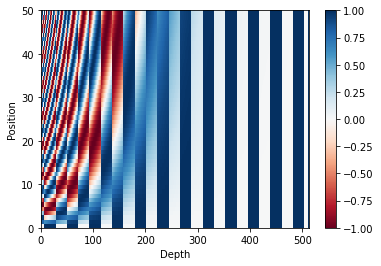

In [0]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [0]:
def create_padding_mask(seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return look_ahead_mask

## Attention

### Attention computation

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $

In [0]:
def scaled_dot_product_attention(queries, keys, values, mask):
    product = tf.matmul(queries, keys, transpose_b=True)
    
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    scaled_product = product / tf.math.sqrt(keys_dim)
    
    if mask is not None:
        scaled_product += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_product, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    attention = tf.matmul(attention_weights, values)
    
    return attention, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [0]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [0]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [0]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [0]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### Multi-head attention sublayer

In [0]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, d_model, nb_proj):
        super(MultiHeadAttention, self).__init__()
        self.nb_proj = nb_proj
        self.d_model = d_model
        
    #def build(self, input_shape):
        #self.d_model = input_shape[-1]
        assert self.d_model % self.nb_proj == 0
        
        self.d_proj = self.d_model // self.nb_proj
        
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        shape = (batch_size,
                 -1,
                 self.nb_proj,
                 self.d_proj)
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        batch_size = tf.shape(queries)[0]
        
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        
        attention, attention_weights = scaled_dot_product_attention(queries, keys, values, mask)
        
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        
        outputs = self.final_lin(concat_attention)
        
        return outputs, attention_weights

Create a MultiHeadAttention layer to try out. At each location in the sequence, y, the MultiHeadAttention runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [0]:
temp_mha = MultiHeadAttention(d_model=512, nb_proj=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(queries=y, keys=y, values=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Encoder

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [0]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, d_model, FFN_units, nb_proj, dropout_rate):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    #def build(self, input_shape):
        #self.d_model = input_shape[-1]
        
        self.multi_head_attention = MultiHeadAttention(self.d_model, self.nb_proj)
        self.ffn = point_wise_feed_forward_network(self.d_model, self.FFN_units)

        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)        
        
        #self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")
        #self.dense_2 = layers.Dense(units=self.d_model)
        
    def call(self, inputs, training, mask):
        attention, _ = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        out1 = self.norm_1(inputs + attention)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout_2(ffn_output, training=training)
        out2 = self.norm_2(out1 + ffn_output)
        #outputs = self.dense_1(attention)
        #outputs = self.dense_2(outputs)
        #outputs = self.dropout_2(outputs, training=training)
        #outputs = self.norm_2(outputs + attention)
        
        return out2

In [0]:
sample_encoder_layer = EncoderLayer(d_model=512, nb_proj=8, FFN_units=2048, dropout_rate=0.1)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [0]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 maximum_position_encoding,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.nb_layers = nb_layers
        self.d_model = d_model
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(d_model, FFN_units, nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, training, mask):

        seq_len = tf.shape(inputs)[1]

        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #outputs += self.pos_encoding(outputs)
        outputs += self.pos_encoding[:, :seq_len, :]
        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](outputs, training, mask)

        return outputs

In [0]:
sample_encoder = Encoder(nb_layers=2, d_model=512, nb_proj=8, 
                         FFN_units=2048, vocab_size=8500,
                         maximum_position_encoding=10000, dropout_rate=0.1)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## Decoder

In [0]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, d_model, FFN_units, nb_proj, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    #def build(self, input_shape):
        #self.d_model = input_shape[-1]
        
        # Self multi head attention
        self.multi_head_attention_1 = MultiHeadAttention(self.d_model, self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention combined with encoder output
        self.multi_head_attention_2 = MultiHeadAttention(self.d_model, self.nb_proj)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn = point_wise_feed_forward_network(self.d_model, self.FFN_units)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, training, look_ahead_mask, padding_mask):
        attention, attention_weights_block1 = self.multi_head_attention_1(inputs,
                                                inputs,
                                                inputs,
                                                look_ahead_mask)
        attention = self.dropout_1(attention, training=training)
        out1 = self.norm_1(attention + inputs)
        
        attention_2, attention_weights_block2 = self.multi_head_attention_2(out1, enc_outputs, enc_outputs, padding_mask)
        attention_2 = self.dropout_2(attention_2, training=training)
        out2 = self.norm_2(attention_2 + out1)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout_3(ffn_output, training=training)
        out3 = self.norm_3(ffn_output + out2)
        
        return out3, attention_weights_block1, attention_weights_block2

In [0]:
sample_decoder_layer = DecoderLayer(d_model=512, nb_proj=8, FFN_units=2048, dropout_rate=0.1)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [0]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 maximum_position_encoding,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.nb_layers = nb_layers
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        self.dec_layers = [DecoderLayer(d_model, FFN_units, nb_proj,
                                        dropout_rate) 
                           for i in range(nb_layers)]
    
    def call(self, inputs, enc_outputs, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(inputs)[1]
        attention_weights = {}
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs += self.pos_encoding[:, :seq_len, :]#(outputs)
        outputs = self.dropout(outputs, training=training)
        
        for i in range(self.nb_layers):
            outputs, block1, block2 = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         training,
                                         look_ahead_mask,
                                         padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return outputs, attention_weights

In [0]:
sample_decoder = Decoder(nb_layers=2, d_model=512, nb_proj=8, 
                         FFN_units=2048, vocab_size=8000,
                         maximum_position_encoding=5000, dropout_rate=0.1)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(inputs=temp_input, 
                              enc_outputs=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer

In [0]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 pe_input,
                 pe_target,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
  
        self.encoder = Encoder(nb_layers=nb_layers,
                               FFN_units=FFN_units,
                               nb_proj=nb_proj,
                               dropout_rate=dropout_rate,
                               vocab_size=vocab_size_enc,
                               maximum_position_encoding=pe_input,
                               d_model=d_model)
        self.decoder = Decoder(nb_layers=nb_layers,
                               FFN_units=FFN_units,
                               nb_proj=nb_proj,
                               dropout_rate=dropout_rate,
                               vocab_size=vocab_size_dec,
                               maximum_position_encoding=pe_target,
                               d_model=d_model)
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def call(self, enc_inputs, dec_inputs, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
          #enc_mask = self.create_padding_mask(enc_inputs)
          #dec_mask_1 = tf.maximum(
          #    self.create_padding_mask(dec_inputs),
          #    self.create_look_ahead_mask(dec_inputs))
          #dec_mask_2 = self.create_padding_mask(enc_inputs)
          
        enc_outputs = self.encoder(enc_inputs, training, enc_padding_mask)
        dec_outputs, attention_weights = self.decoder(dec_inputs,
                                                      enc_outputs,
                                                      training, 
                                                      look_ahead_mask,
                                                      dec_padding_mask)
        
        outputs = self.last_linear(dec_outputs)
        
        return outputs, attention_weights

In [0]:
sample_transformer = Transformer(
    nb_layers=2, d_model=512, nb_proj=8, FFN_units=2048, 
    vocab_size_enc=8500, vocab_size_dec=8000, pe_input=10000, pe_target=6000, dropout_rate=0.1)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(enc_inputs=temp_input,
                               dec_inputs=temp_target,
                               training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Training

In [0]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = 128 # 512
NB_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
NB_PROJ = 8 # 8
DROPOUT_RATE = 0.1 # 0.1

VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2
VOCAB_SIZE_ES = tokenizer_es.vocab_size + 2

transformer = Transformer(vocab_size_enc=VOCAB_SIZE_EN,
                          vocab_size_dec=VOCAB_SIZE_ES,
                          d_model=D_MODEL,
                          nb_layers=NB_LAYERS,
                          FFN_units=FFN_UNITS,
                          nb_proj=NB_PROJ,
                          pe_input=VOCAB_SIZE_EN,
                          pe_target=VOCAB_SIZE_ES,
                          dropout_rate=DROPOUT_RATE)

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")

def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

leaning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
        

Text(0.5, 0, 'Train Step')

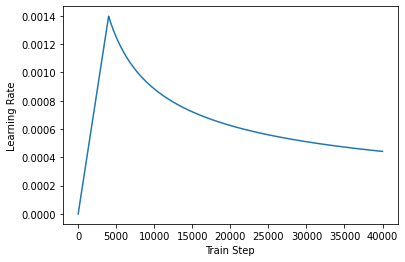

In [0]:
temp_learning_rate_schedule = CustomSchedule(D_MODEL)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
checkpoint_path = "./drive/My Drive/en-es/Checkpoint"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

Latest checkpoint restored!!


```
# Each epoch takes around 2 hours to run. We have trained and saved the model as checkpoint. 

EPOCHS = 3
for epoch in range(EPOCHS):
    print("Start of epoch {}".format(epoch+1))
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        dec_inputs = targets[:, :-1]
        dec_outputs_real = targets[:, 1:]
        
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(enc_inputs, dec_inputs)
        
        with tf.GradientTape() as tape:
            predictions, _ = transformer(enc_inputs,
                                     dec_inputs,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
            loss = loss_function(dec_outputs_real, predictions)
        
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % 50 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
       
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} at {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Time taken for 1 epoch: {} secs\n".format(time.time() - start))

```

# Evaluating

In [0]:
def evaluate(inp_sentence):
    inp_sentence = \
        [VOCAB_SIZE_EN-2] + tokenizer_en.encode(inp_sentence) + [VOCAB_SIZE_EN-1]
    enc_input = tf.expand_dims(inp_sentence, axis=0)
    
    output = tf.expand_dims([VOCAB_SIZE_ES-2], axis=0)
    
    for _ in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(enc_input, output)
        
        predictions, attention_weights = transformer(enc_input, output, False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        prediction = predictions[:, -1:, :]
        
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        
        if predicted_id == VOCAB_SIZE_ES-1:
            return tf.squeeze(output, axis=0), attention_weights
        
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis=0), attention_weights

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_en.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_en.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_es.decode([i]) for i in result 
                        if i < tokenizer_es.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
def translate(sentence, plot=''):
    #output, attention_weights = evaluate(sentence).numpy()
    output, attention_weights = evaluate(sentence)
    
    predicted_sentence = tokenizer_es.decode(
        [i for i in output if i < VOCAB_SIZE_ES-2]
    )
    
    print("Input: {}".format(sentence))
    print("Predicted translation: {}".format(predicted_sentence))

    if plot:
      plot_attention_weights(attention_weights, sentence, output, plot)

In [0]:
translate("I am Harsh")

Input: I am Harsh
Predicted translation: Estoy hablando de Harbovino


In [0]:
translate("Let there be world peace")

Input: Let there be world peace
Predicted translation: Hablemos de paz mundial


Input: Hi I am from India.
Predicted translation: Hi la India.


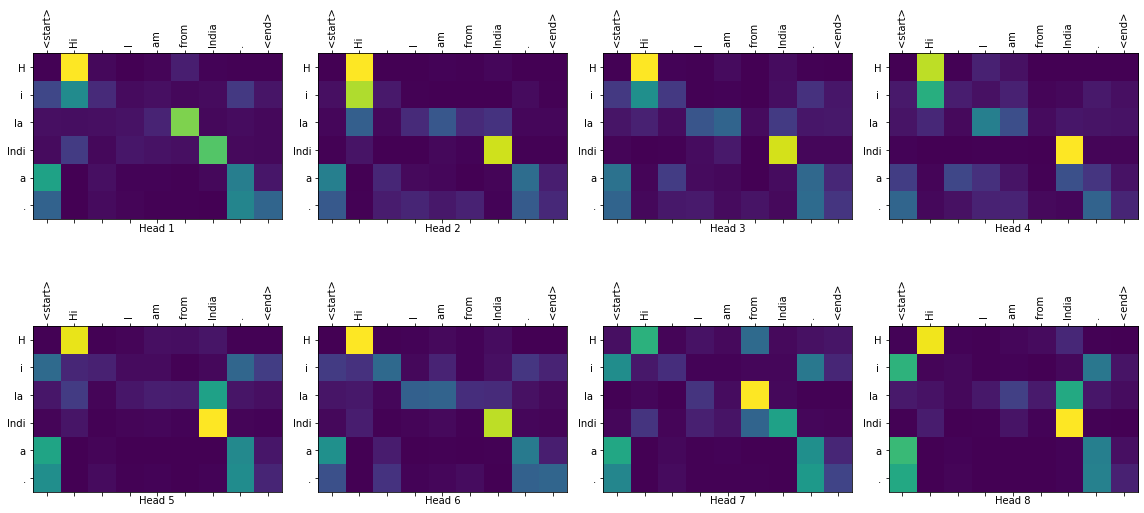

In [0]:
translate("Hi I am from India.", plot='decoder_layer4_block2')

In [0]:
print("🆂🅿🅰🅽🅸🆂🅷 101")
print("𝗔𝗶𝗿𝗹𝗶𝗻𝗲 𝗰𝗼𝗺𝗽𝗮𝗻𝘆 𝗶𝗻 𝗣𝗮𝗿𝗶𝘀 :")
translate("Do you speak Spanish ?")
print("𝐘𝐨𝐮:")
translate("No, I don't speak Spanish,I speak English.")
print("𝐘𝐨𝐮:")
translate("I would like to reserve a flight for US from Paris.")
print("𝗔𝗶𝗿𝗹𝗶𝗻𝗲 𝗰𝗼𝗺𝗽𝗮𝗻𝘆 𝗶𝗻 𝗣𝗮𝗿𝗶𝘀 :")
translate("The departure is at 12:00 hours.")
print("𝐘𝐨𝐮:")
translate("It's good.")
print("𝗔𝗶𝗿𝗹𝗶𝗻𝗲 𝗰𝗼𝗺𝗽𝗮𝗻𝘆 𝗶𝗻 𝗣𝗮𝗿𝗶𝘀 :")
translate("Your reservation for US is confirmed.")
print("𝐘𝐨𝐮:")
translate("Thank You ")
print("𝗔𝗶𝗿𝗹𝗶𝗻𝗲 𝗰𝗼𝗺𝗽𝗮𝗻𝘆 𝗶𝗻 𝗣𝗮𝗿𝗶𝘀 :")
translate("Please give me five Stars.")

🆂🅿🅰🅽🅸🆂🅷 101
𝗔𝗶𝗿𝗹𝗶𝗻𝗲 𝗰𝗼𝗺𝗽𝗮𝗻𝘆 𝗶𝗻 𝗣𝗮𝗿𝗶𝘀 :
Input: Do you speak Spanish ?
Predicted translation: ¿Tiene usted la palabra el SPE?
𝐘𝐨𝐮:
Input: No, I don't speak Spanish,I speak English.
Predicted translation: No, no hablo de Scaer inglés
𝐘𝐨𝐮:
Input: I would like to reserve a flight for US from Paris.
Predicted translation: Quisiera reservar un vuelo para los Estados Unidos de París.
𝗔𝗶𝗿𝗹𝗶𝗻𝗲 𝗰𝗼𝗺𝗽𝗮𝗻𝘆 𝗶𝗻 𝗣𝗮𝗿𝗶𝘀 :
Input: The departure is at 12:00 hours.
Predicted translation: El tema es el de las 12:
𝐘𝐨𝐮:
Input: It's good.
Predicted translation: Lo bueno es el bien.
𝗔𝗶𝗿𝗹𝗶𝗻𝗲 𝗰𝗼𝗺𝗽𝗮𝗻𝘆 𝗶𝗻 𝗣𝗮𝗿𝗶𝘀 :
Input: Your reservation for US is confirmed.
Predicted translation: Su reserva de los EEUU confirma la confirmación.
𝐘𝐨𝐮:
Input: Thank You 
Predicted translation: Muchas gracias
𝗔𝗶𝗿𝗹𝗶𝗻𝗲 𝗰𝗼𝗺𝗽𝗮𝗻𝘆 𝗶𝗻 𝗣𝗮𝗿𝗶𝘀 :
Input: Please give me five Stars.
Predicted translation: Le ruego que me diera cinco leídos.


Input: This is the World Health Organization
Predicted translation: Ésa es la Organización Mundial de la Saluda


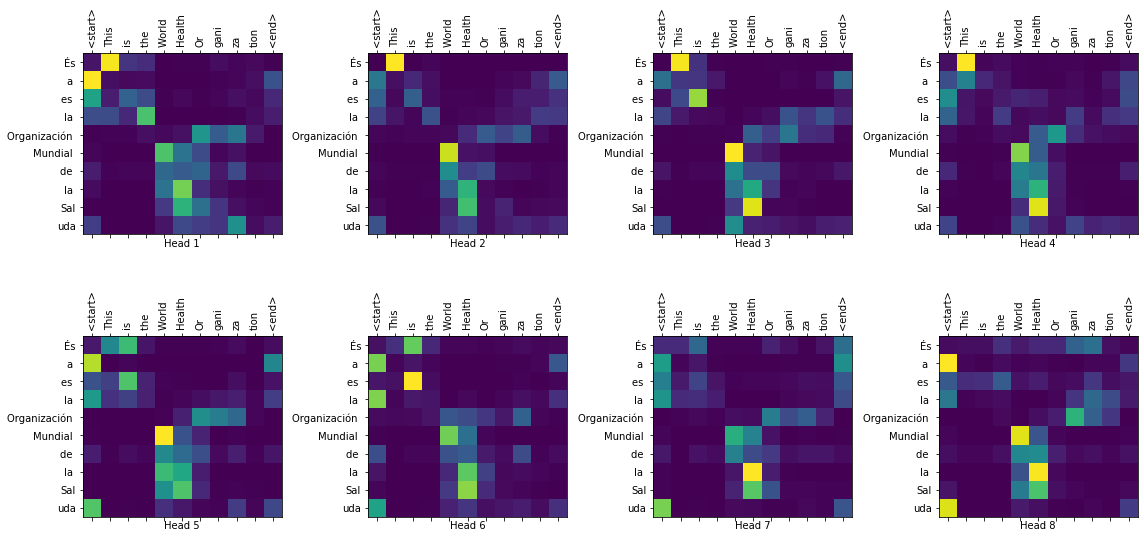

In [0]:
translate("This is the World Health Organization", plot='decoder_layer4_block2')